In [4]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


In [5]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=DeprecationWarning)

We are taking a ravdess emotion dataset

In [8]:
Ravd = r"C:\Users\pav\OneDrive\Desktop\archive\audio_speech_actors_01-24"

In [9]:
dirl = os.listdir(Ravd)
dirl.sort()
emotion = []
gender = []
path = []
for i in dirl:
    dir_path = os.path.join(Ravd, i)  # Create a valid directory path
    fname = os.listdir(dir_path)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(os.path.join(dir_path, f))  # Create a valid file path

In [10]:
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

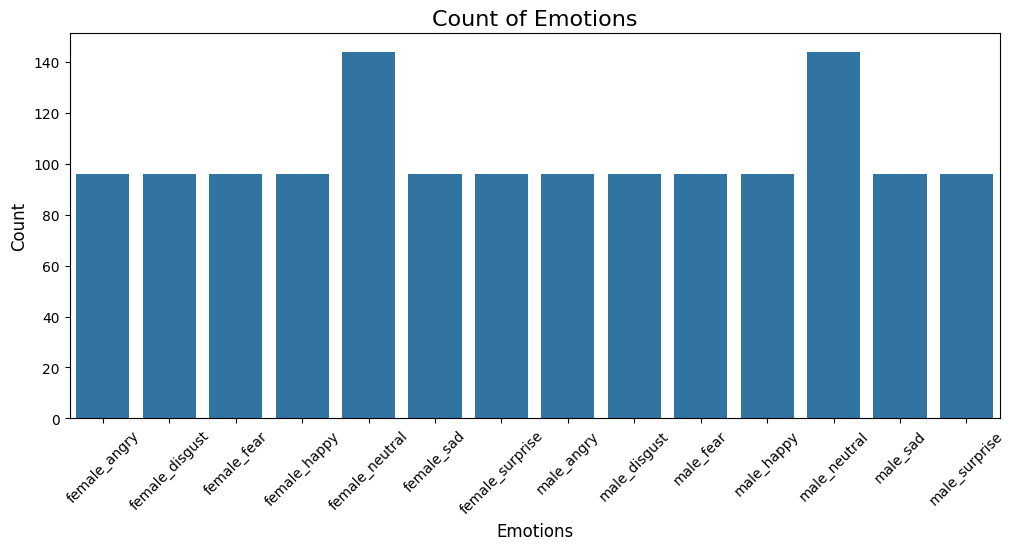

In [11]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
RAVD_df['labels'] = RAVD_df['labels'].astype('category')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.countplot(x='labels', data=RAVD_df)
plt.show()

Female-sad emotion

In [12]:
fRA01= Ravd + '/Actor_06/03-01-04-01-02-02-06.wav'
data, sr = librosa.load(fRA01)
ipd.Audio(data, rate=sr)

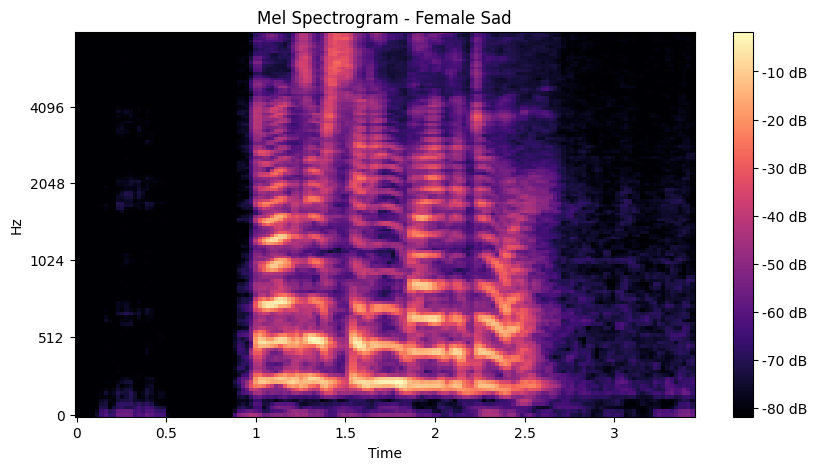

In [13]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Female Sad')
plt.colorbar(format='%+2.0f dB');

Female-happy emotion

In [14]:
fRA02= Ravd + '/Actor_06/03-01-03-02-02-01-06.wav'
data, sr = librosa.load(fRA02)
ipd.Audio(data, rate=sr)

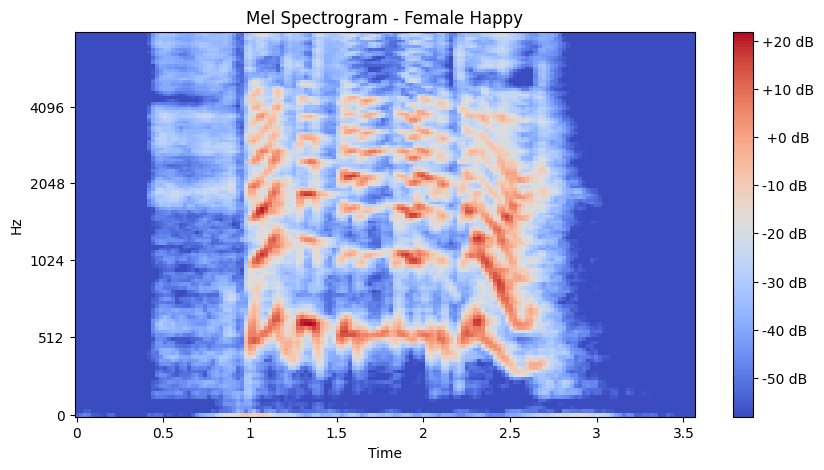

In [15]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+3.0f dB');

Male-sad

In [16]:
fRA11= Ravd + '/Actor_05/03-01-04-01-02-02-05.wav'
data, sr = librosa.load(fRA11)
ipd.Audio(data, rate=sr)

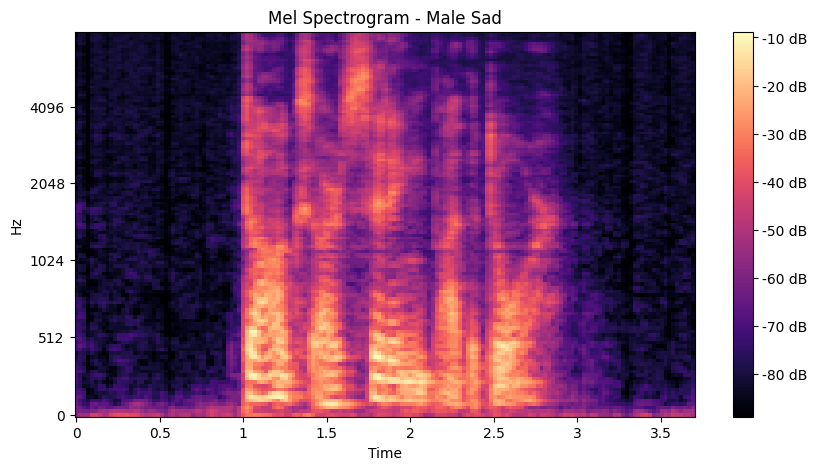

In [17]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Male Sad')
plt.colorbar(format='%+2.0f dB');

Male-Happy emotion

In [18]:
fRA12= Ravd + '/Actor_05/03-01-03-01-02-02-05.wav'
data, sr = librosa.load(fRA12)
ipd.Audio(data, rate=sr)

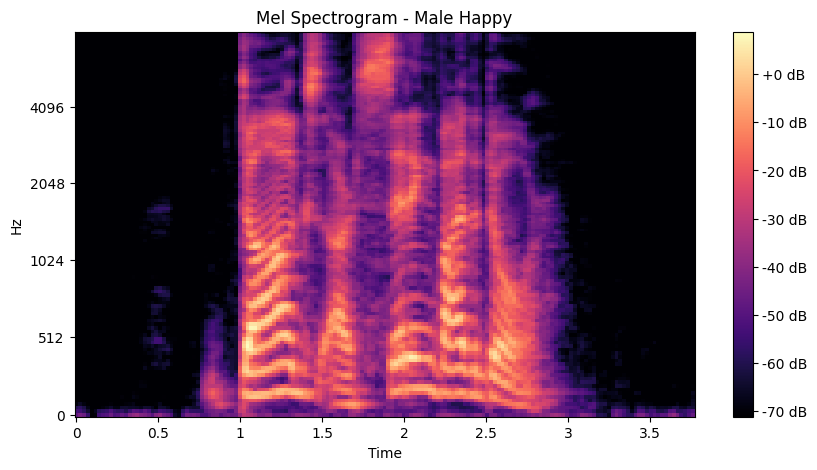

In [19]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram,y_axis='mel',fmax=8000,x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.colorbar(format='%+2.0f dB');

# DATA AUGMENTATION

In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [21]:
path = np.array(RAVD_df['path'])[472]
data, sample_rate = librosa.load(path)

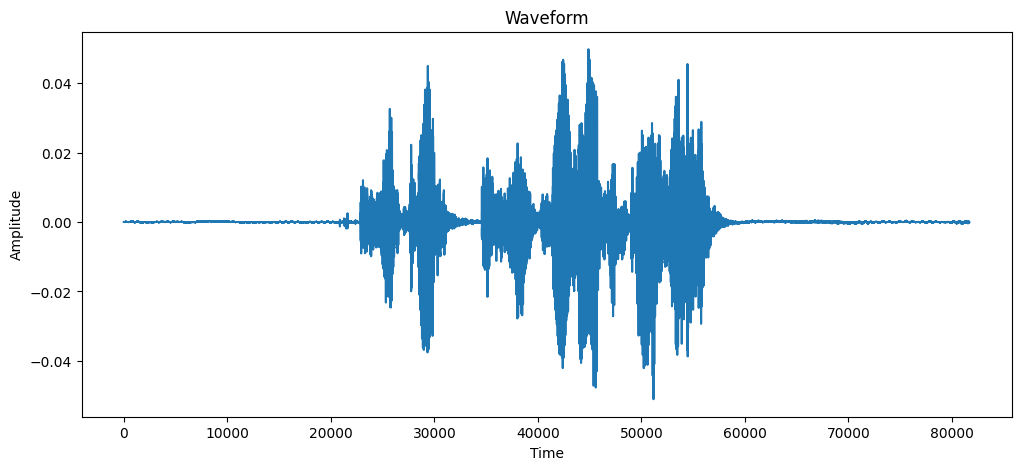

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

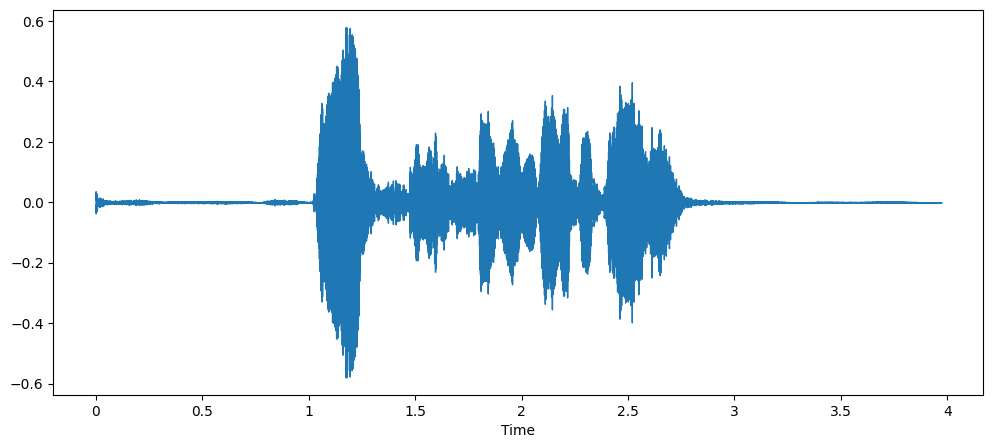

In [32]:
# NORMAL AUDIO
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio file
path =r"C:\Users\pav\OneDrive\Desktop\archive\audio_speech_actors_01-24\Actor_01\03-01-06-02-02-01-01.wav" # Replace with the actual path to your audio file
data, sample_rate = librosa.load(path)

# Display the audio waveform
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.show()

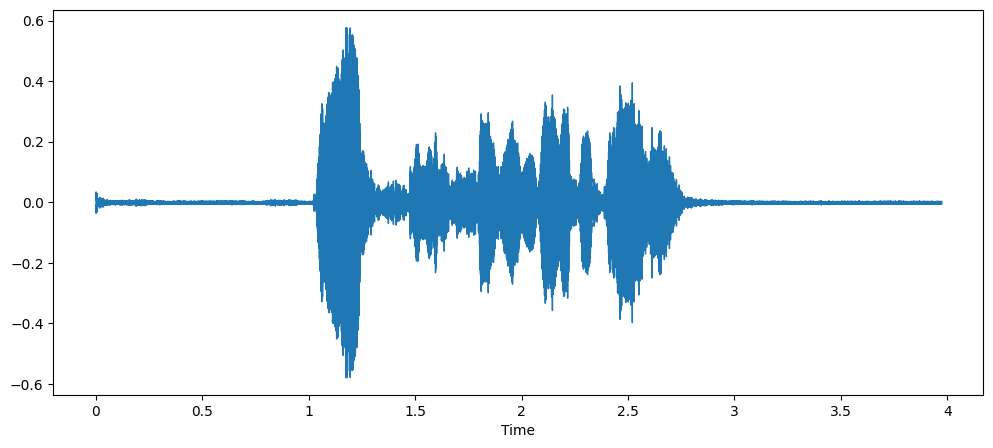

In [33]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

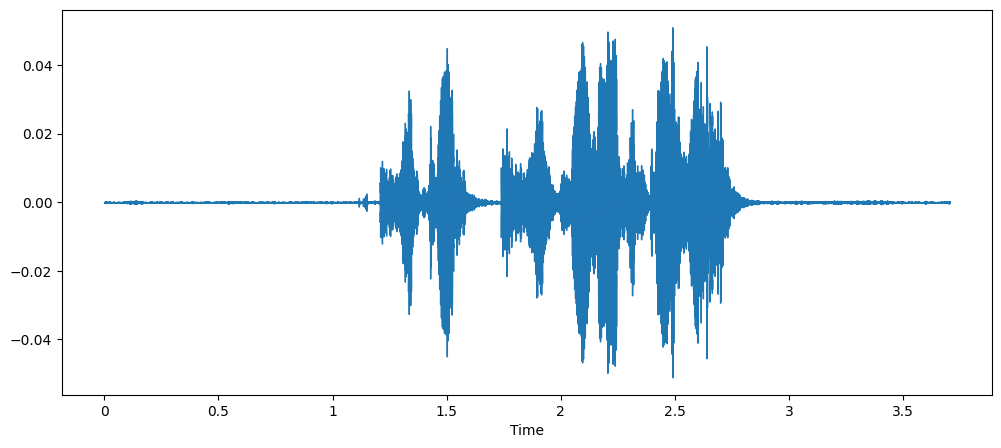

In [40]:
#SHIFT
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

After listening to all audio we determine to use noise, shift 

# FEATURE EXTRACTION

In [34]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    return result


In [35]:
RAVD_df.head()

,labels,source,path
0,male_neutral,RAVDESS,C:\Users\pav\OneDrive\Desktop\archive\audio_sp...
1,male_neutral,RAVDESS,C:\Users\pav\OneDrive\Desktop\archive\audio_sp...
2,male_neutral,RAVDESS,C:\Users\pav\OneDrive\Desktop\archive\audio_sp...
3,male_neutral,RAVDESS,C:\Users\pav\OneDrive\Desktop\archive\audio_sp...
4,male_neutral,RAVDESS,C:\Users\pav\OneDrive\Desktop\archive\audio_sp...


In [36]:
x,y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        x.append(ele)
        y.append(emotion)

In [37]:
Emotions = pd.DataFrame(x)
Emotions['labels'] = y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-645.880737,72.619637,0.841306,16.399446,10.241593,0.653901,-4.328001,-4.258932,-14.575824,-3.806285,...,-4.042665,2.519602,-4.972247,0.566447,1.035527,-5.416451,-2.449469,-1.782306,-1.212806,male_neutral
1,-461.602233,34.596950,7.826320,9.551138,6.393068,0.002678,-3.661553,-7.424431,-10.038362,-6.632628,...,-1.574544,-0.942105,-1.346742,-0.752543,-0.322503,-3.840422,-3.329540,0.137212,-2.808296,male_neutral
2,-634.663269,72.324066,-2.998578,20.209740,10.674218,-1.151011,-2.813592,-7.923956,-16.231958,-2.627547,...,-4.167823,0.719305,-4.954944,-0.688254,0.114427,-6.475232,-1.695712,-2.899729,0.377746,male_neutral
3,-437.360156,29.003986,8.982831,10.172485,5.776343,-0.623509,-3.074341,-7.396996,-9.115495,-4.941011,...,-2.569300,-1.903959,-1.770740,-0.098417,-0.252398,-3.410576,-2.560204,-0.697410,-2.029402,male_neutral
4,-643.285706,74.262276,-1.228256,16.242317,5.608831,0.250306,-4.034254,-8.218330,-14.603806,-5.804611,...,-4.506181,1.656076,-5.158418,-3.169353,0.728493,-6.893911,-4.407825,-0.179896,-0.131767,male_neutral


In [38]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-645.880737,72.619637,0.841306,16.399446,10.241593,0.653901,-4.328001,-4.258932,-14.575824,-3.806285,...,-4.042665,2.519602,-4.972247,0.566447,1.035527,-5.416451,-2.449469,-1.782306,-1.212806,male_neutral
1,-461.602233,34.596950,7.826320,9.551138,6.393068,0.002678,-3.661553,-7.424431,-10.038362,-6.632628,...,-1.574544,-0.942105,-1.346742,-0.752543,-0.322503,-3.840422,-3.329540,0.137212,-2.808296,male_neutral
2,-634.663269,72.324066,-2.998578,20.209740,10.674218,-1.151011,-2.813592,-7.923956,-16.231958,-2.627547,...,-4.167823,0.719305,-4.954944,-0.688254,0.114427,-6.475232,-1.695712,-2.899729,0.377746,male_neutral
3,-437.360156,29.003986,8.982831,10.172485,5.776343,-0.623509,-3.074341,-7.396996,-9.115495,-4.941011,...,-2.569300,-1.903959,-1.770740,-0.098417,-0.252398,-3.410576,-2.560204,-0.697410,-2.029402,male_neutral
4,-643.285706,74.262276,-1.228256,16.242317,5.608831,0.250306,-4.034254,-8.218330,-14.603806,-5.804611,...,-4.506181,1.656076,-5.158418,-3.169353,0.728493,-6.893911,-4.407825,-0.179896,-0.131767,male_neutral


# DATA PREPROCESSING

In [39]:
x = Emotions.iloc[: ,:-1].values
y= Emotions['labels'].values

In [40]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
# Train and Test Split 
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 20), (2160, 14), (720, 20), (720, 14))

In [41]:
# Reshape for LSTM 
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [42]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 20), (2160, 14), (720, 20), (720, 14))

In [43]:
model=Sequential()
model.add(LSTM(512,return_sequences=True,input_shape=(40,1)))
model.add(LSTM(512,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(LSTM(256,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(LSTM(128,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(LSTM(64,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(14))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [44]:
X_train_padded = np.pad(X_train, ((0,0), (20,0), (0,0)), mode='constant')

# Pad the test data
X_test_padded = np.pad(X_test, ((0,0), (20,0), (0,0)), mode='constant')

# Now, the input data has the expected shape of (None, 40, 1)
# We can train the model on the padded input data

model.fit(X_train_padded, y_train, epochs=100, validation_data=(X_test_padded, y_test), batch_size=65, verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 561ms/step - accuracy: 0.1187 - loss: 0.0661 - val_accuracy: 0.1653 - val_loss: 0.0649
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - accuracy: 0.1888 - loss: 0.0643 - val_accuracy: 0.1736 - val_loss: 0.0642
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 669ms/step - accuracy: 0.1918 - loss: 0.0632 - val_accuracy: 0.2333 - val_loss: 0.0616
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - accuracy: 0.2047 - loss: 0.0619 - val_accuracy: 0.2083 - val_loss: 0.0624
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 540ms/step - accuracy: 0.1959 - loss: 0.0625 - val_accuracy: 0.2750 - val_loss: 0.0606
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 587ms/step - accuracy: 0.2266 - loss: 0.0616 - val_accuracy: 0.2444 - val_loss: 0.0614
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 575ms/step - accuracy: 0.2338 - loss: 0.0607 - val_accuracy: 0.2597 - val_loss: 0.0603
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - accuracy: 0.2306 - loss: 0.0615 - 

# UTILIZING MODELS

**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier()
clf1 = clf1.fit(x_train,y_train)
y_pred = clf1.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

After Using the decision tree model in our dataset then the model goes in overfitting he gave accuracy around 0.385

**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf2=KNeighborsClassifier(n_neighbors=4)
clf2.fit(x_train,y_train)

In [ ]:
y_pred=clf2.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Using KNN in our dataset the overall training is quite good but not for deployment and test accuracy has 0.336

**MLP CLASSIFIER**

In [50]:
from sklearn.neural_network import MLPClassifier
clf3=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf3.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400)

In [51]:
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))

Training set score: 0.911
Test set score: 0.590


Using MLP Classifier he gave good accuracy in training dataset butit is not good for our test set, So we did not use it for deployment

# GRU

In [52]:
model03 = Sequential()
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, activation='tanh'))
model03.add(Dropout(0.3))
model03.add(Dense(units=14))
model03.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error', metrics=['accuracy'])


In [53]:
model03.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 20, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 20, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             714 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,564 (213.14 KB)

 Trainable params: 54,564 (213.14 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model03.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=200)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.0947 - loss: 0.0945 - val_accuracy: 0.1556 - val_loss: 0.0681
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0952 - loss: 0.0806 - val_accuracy: 0.1931 - val_loss: 0.0668
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0936 - loss: 0.0764 - val_accuracy: 0.1708 - val_loss: 0.0663
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0952 - loss: 0.0732 - val_accuracy: 0.1778 - val_loss: 0.0660
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0796 - loss: 0.0719 - val_accuracy: 0.1944 - val_loss: 0.0656
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1044 - loss: 0.0710 - val_accuracy: 0.1875 - val_loss: 0.0654
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1146 - loss: 0.0696 - val_accuracy: 0.1861 - val_loss: 0.0653
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1201 - loss: 0.0693 - val_accuracy: 0

In [55]:
print("Accuracy of our model on test data : " , model03.evaluate(X_test,y_test)[1]*100 , "%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2255 - loss: 0.0637
Accuracy of our model on test data :  22.638888657093048 %


GRU(Gated Recurrent Unit) is important when we use speech dataset but in this model, we don't have good accuracy in training set as well as testing so we do not take for further deployment.

# LSTM

In [56]:
model13=Sequential()
model13.add(LSTM(70,return_sequences=True,input_shape=(20,1)))
model13.add(LSTM(50,return_sequences=True))
model13.add(LSTM(60))
model13.add(Dense(14))
model13.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [57]:
model13.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 20, 70)              │          20,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 20, 50)              │          24,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 60)                  │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │             854 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,854 (280.68 KB)

 Trainable params: 71,854 (280.68 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
 model13.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=65,verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1482 - loss: 0.0670 - val_accuracy: 0.2625 - val_loss: 0.0622
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2363 - loss: 0.0622 - val_accuracy: 0.2847 - val_loss: 0.0610
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2600 - loss: 0.0607 - val_accuracy: 0.2833 - val_loss: 0.0604
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2841 - loss: 0.0599 - val_accuracy: 0.2833 - val_loss: 0.0603
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2882 - loss: 0.0597 - val_accuracy: 0.3000 - val_loss: 0.0601
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3145 - loss: 0.0584 - val_accuracy: 0.3028 - val_loss: 0.0594
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3153 - loss: 0.0582 - val_accuracy: 0.2903 - val_loss: 0.0595
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3009 - loss: 0.0585 - val_accuracy: 0.

In [59]:
print("Accuracy of our model on test data : " , model13.evaluate(X_test,y_test)[1]*100 , "%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5391 - loss: 0.0504
Accuracy of our model on test data :  52.91666388511658 %


So, After all, the model ran we use LSTM is important when using sequence data like speech, So using this it ran good on train set but in the test is not so good i.e. 55.28 percentage.

# CNN

In [ ]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

In [ ]:
#CNN
import tensorflow as tf 
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

In [62]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 825ms/step - accuracy: 0.0742 - loss: 2.6285 - val_accuracy: 0.1097 - val_loss: 2.6333
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 884ms/step - accuracy: 0.1163 - loss: 2.5919 - val_accuracy: 0.1111 - val_loss: 2.6327
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - accuracy: 0.1498 - loss: 2.5554 - val_accuracy: 0.1028 - val_loss: 2.6314
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 732ms/step - accuracy: 0.1871 - loss: 2.5110 - val_accuracy: 0.1028 - val_loss: 2.6409
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 726ms/step - accuracy: 0.1944 - loss: 2.4692 - val_accuracy: 0.1028 - val_loss: 2.6351
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 904ms/step - accuracy: 0.2120 - loss: 2.3734 - val_accuracy: 0.1028 - val_loss: 2.6292
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 920ms/step - accuracy: 0.2279 - loss: 2.3127 - val_accuracy: 0.1028 - val_loss: 2.6099
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2580 - loss: 2.2481 - val

In [63]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7716 - loss: 1.8570
Accuracy of our model on test data :  75.83333253860474 %


So Using all models we use last but not least CNN after using the CNN model we got good accuracy in the train as well as test if you saw the test accuracy above cell is quite good so we use further deployment

# Loss Accuracy Plot Using CNN

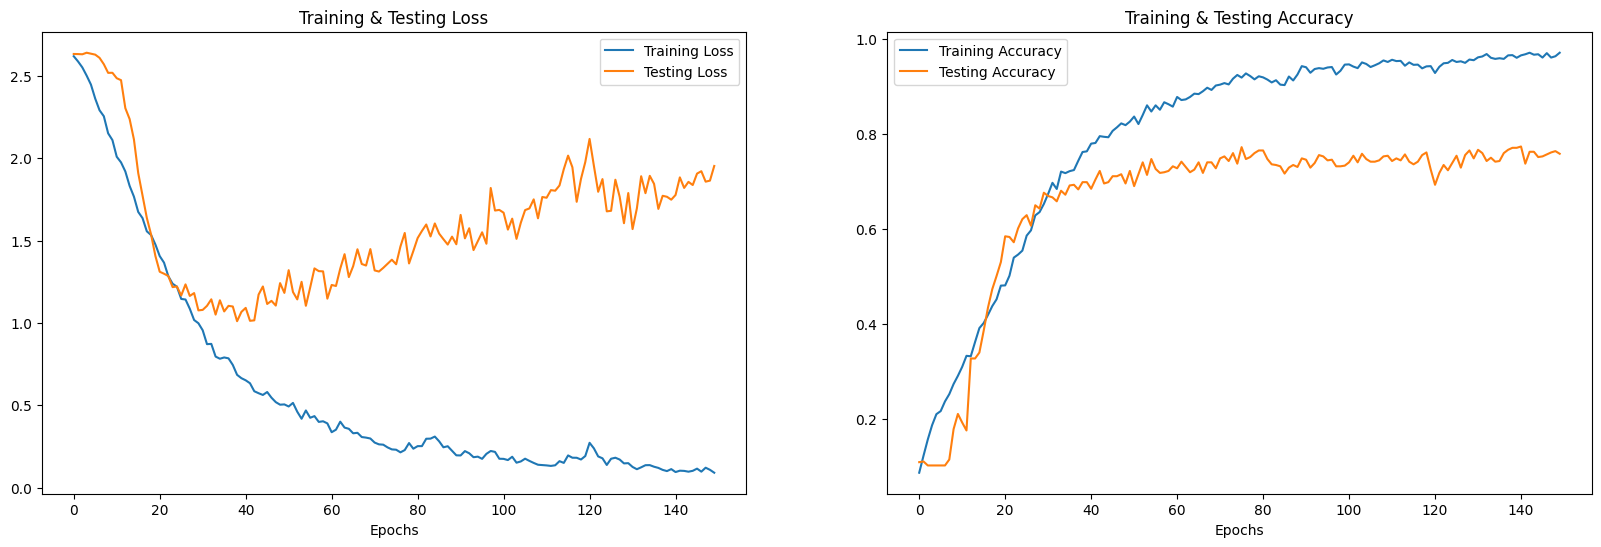

In [64]:
#CNN
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [65]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


,Predicted Labels,Actual Labels
0,male_disgust,male_disgust
1,male_disgust,male_disgust
2,female_neutral,female_neutral
3,female_neutral,female_neutral
4,female_neutral,female_neutral
5,male_neutral,male_neutral
6,female_angry,female_sad
7,female_neutral,female_neutral
8,female_neutral,female_neutral
9,female_disgust,female_disgust


# Confusion Matrix Using CNN

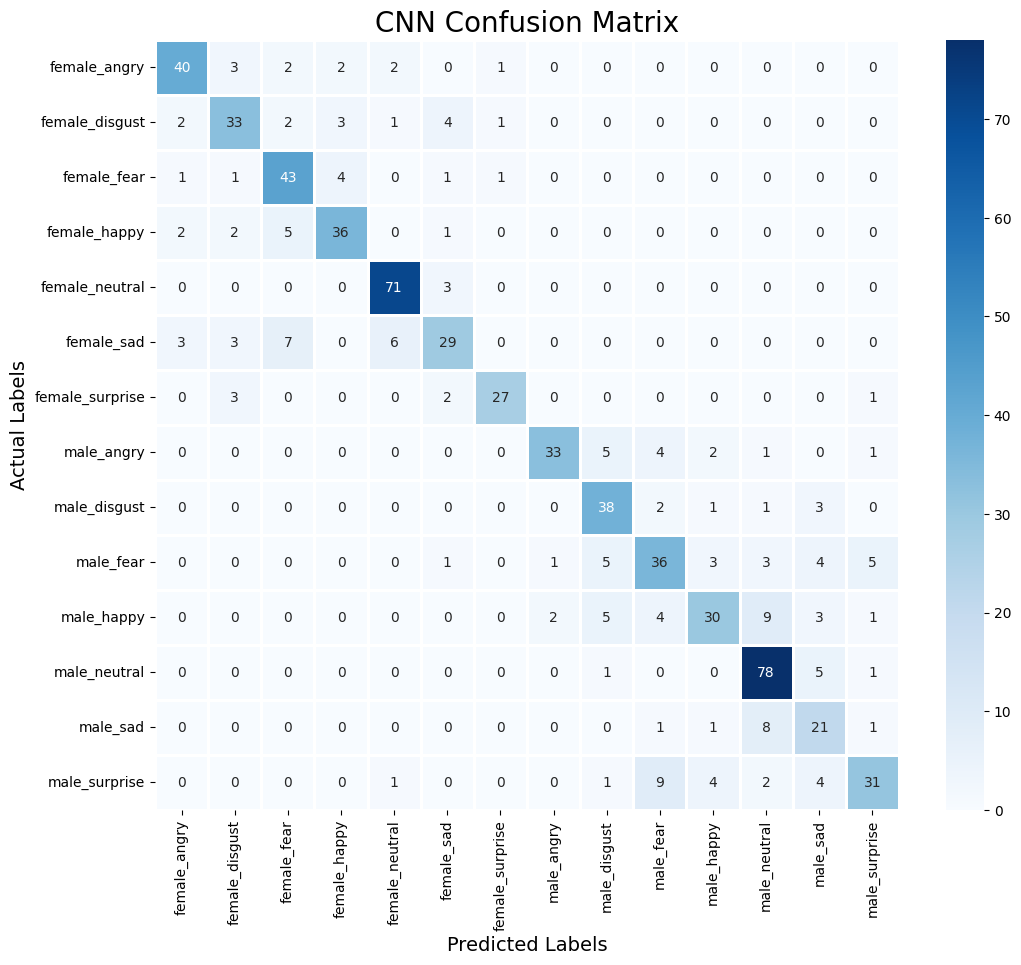

In [66]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('CNN Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report Using CNN

In [67]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.83      0.80      0.82        50
 female_disgust       0.73      0.72      0.73        46
    female_fear       0.73      0.84      0.78        51
   female_happy       0.80      0.78      0.79        46
 female_neutral       0.88      0.96      0.92        74
     female_sad       0.71      0.60      0.65        48
female_surprise       0.90      0.82      0.86        33
     male_angry       0.92      0.72      0.80        46
   male_disgust       0.69      0.84      0.76        45
      male_fear       0.64      0.62      0.63        58
     male_happy       0.73      0.56      0.63        54
   male_neutral       0.76      0.92      0.83        85
       male_sad       0.53      0.66      0.58        32
  male_surprise       0.76      0.60      0.67        52

       accuracy                           0.76       720
      macro avg       0.76      0.75      0.75       720
   weighted avg       0.76   

After completing the all training part we got good accuracy using CNN so we plot the confusion matrix and classification report.

In [71]:
import os
model_name = 'model_cnn'  # Remove the .h5 extension
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, f'{model_name}.keras')  # Use .keras extension
model.save(model_path)
print(f'Saved trained model at {model_path}')

Saved trained model at C:\Users\pav\OneDrive\Desktop\saved_models\model_cnn.keras


In [72]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [76]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(r"C:\Users\pav\OneDrive\Desktop\saved_models\model_cnn.keras")
print("Loaded model from disk")

Loaded model from disk


# LIVE DEMO

In [77]:
data, sampling_rate = librosa.load(r"C:\Users\pav\OneDrive\Desktop\archive\audio_speech_actors_01-24\Actor_01\03-01-06-02-02-01-01.wav")

In [78]:
import os
import pandas as pd
import librosa
import glob 

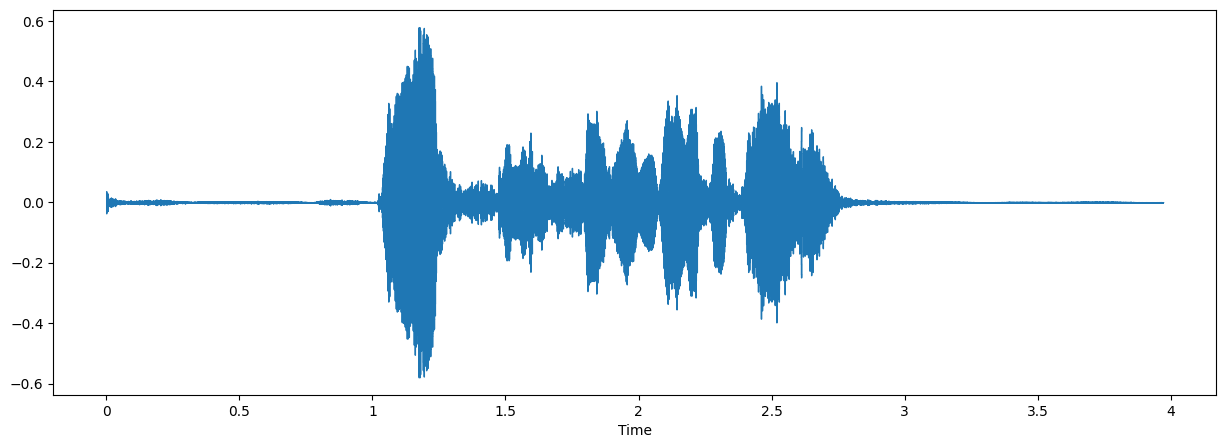

In [79]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [82]:
import soundfile as sf
import numpy as np
import librosa
from scipy import signal

# Load the audio file
file_path = r"C:\Users\pav\OneDrive\Desktop\archive\audio_speech_actors_01-24\Actor_01\03-01-06-02-02-01-01.wav"
audio, sample_rate = sf.read(file_path)

# Resample the audio to the desired sample rate
target_sample_rate = 22050*2
if sample_rate!= target_sample_rate:
    audio = signal.resample(audio, int(len(audio) * target_sample_rate / sample_rate))
    sample_rate = target_sample_rate

# Extract MFCC features from the audio
mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=0)
features = mfccs
livedf = features

# Process the extracted features as needed
# ...

# Use the features for speech emotion recognition
# ...


In [83]:
livedf= pd.DataFrame(data=livedf)
livedf = livedf.stack().to_frame().T
livedf

,0,1,2,3,4,5,6,7,8,9,...,333,334,335,336,337,338,339,340,341,342
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-16.29295,-19.148231,-30.00579,-30.372893,-31.876699,-33.669777,-34.968816,-34.125838,-31.368385,-28.949561,...,-40.728868,-43.456805,-43.564754,-44.174231,-44.321002,-44.401221,-44.538174,-45.130988,-45.146727,-45.13736


In [84]:
dim2= np.expand_dims(livedf, axis=2)

In [87]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the 2D array or list of sequences
twodim = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]  # Replace with your actual data

# Pad or truncate the sequence length to 20
maxlen = 20
twodim_padded = pad_sequences(twodim, maxlen=maxlen, dtype='float32', padding='post', truncating='post', value=0.0)

# Use the padded input data to make predictions
livepreds = loaded_model.predict(twodim_padded, batch_size=32, verbose=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


In [88]:
result = (encoder.inverse_transform((livepreds)))
result

array([['female_angry'],
       ['female_angry'],
       ['female_happy']], dtype=object)